In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt

#Grid point characteristics

class Grid_point:
    def __init__(self, r, theta, phi, beam, g):
        self.r = r
        self.theta = theta
        self.phi = phi
        self.beam = beam
        self.g = g


#Transform microphone positions to spherical coordinates
        
def get_spherical_from_cart(m):
    n = [] #microphone values in spherical coordinates
    for i in range(len(m)):
        r = np.sqrt(m[i][0]**2 + m[i][1]**2)
        theta = np.arctan2(m[i][1], m[i][0])
        n.append([r,theta*180/np.pi,90]) #radius, position angle, vertical angle (always 90 since it is on the same plane)
    return n

#Calculate the steering vectors 

def get_steering_vector(scan_r, scan_theta, scan_phi):
    g = []
    for i in range(len(m)):
        #r = np.sqrt((scan_r)**2 + (m[i][0])**2 - 
         #           2*scan_r*m[i][0]*(np.sin(scan_theta*np.pi/180)*np.sin(m[i][1]*np.pi/180)*np.cos((scan_phi - m[i][2])*np.pi/180) 
          #                            + np.cos(scan_theta*np.pi/180)*np.cos(m[i][1]*np.pi/180)))
        r = np.sqrt((scan_r*np.cos(scan_phi*np.pi/180))**2 +
                    (scan_r*np.sin(scan_phi*np.pi/180)*np.cos(scan_theta*np.pi/180) - m[i][0]*np.sin(m[i][2]*np.pi/180)*np.cos(m[i][1]*np.pi/180))**2 +
                    (scan_r*np.sin(scan_phi*np.pi/180)*np.sin(scan_theta*np.pi/180) - m[i][0]*np.sin(m[i][2]*np.pi/180)*np.sin(m[i][1]*np.pi/180))**2)
        z = complex(np.cos(2*np.pi*F*r/C), -np.sin(2*np.pi*F*r/C))
        g.append(z/r)
    g = np.array(g)
    return g

#Main program

#Define constants
C = 343 #m/s - speed of sound
F = 800 #Hz - frequency obtained from spectogram

#Read pressure measurements

p = [] 

with open("C:\\Users\\Jakub\\OneDrive - Delft University of Technology\Desktop\\test analysis project\\Microphone data\\ANWB.csv", newline='') as drone_file:
    reader = csv.reader(drone_file)
    for row in reader:
        if len(row[0])==0:
            break
        aux = []
        for i in range(len(row)):
            if i!=0 and i!=16 and i!=20 and i!=40 and i<62:
                aux.append(float(row[i]))
        p.append(aux)

p = np.array(p) #Columns are p measurements for the same microphone and diff time instances
          #and rows are for same time instance and different microphones

#Read microphone coordinates

m = [] #Microphone coordinates (x,y) wrt the center of the array

with open("config.txt") as m_file:
    for line in m_file:
        words = line.split()
        if words[0]!="1" and words[0]!="17" and words[0]!="21" and words[0]!="41" and words[0]!="63" and words[0]!="64":
            m.append([float(words[1]),float(words[2])])

m = get_spherical_from_cart(m)



<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Jakub\AppData\Local\Temp\ipykernel_63296\2913023801.py:52: SyntaxWarning: invalid escape sequence '\D'
  with open("C:\\Users\\Jakub\\OneDrive - Delft University of Technology\Desktop\\test analysis project\\Microphone data\\ANWB.csv", newline='') as drone_file:


In [5]:

#Construct the grid
grid = []

dtheta = 1
dphi = 0.5
phi = 90
r = 450

while phi > 0:
    theta = -180
    while theta < 180:
        grid_point = Grid_point(r, theta, phi, 0, [])
        grid.append(grid_point)
        theta += dtheta
    phi -= dphi

#Construct the steering vectors

for i in range(len(grid)):
    grid[i].g = get_steering_vector(grid[i].r, grid[i].theta, grid[i].phi)

#Prepare the plot
    
x_axis = [] #Horizontal axis is theta
y_axis = [] #Vertical axis is phi

theta = -180
while theta < 180:
    x_axis.append(theta)
    theta += dtheta
x_axis.append(180)
y_axis.append(0)

phi = 90
while phi > 0:
    y_axis.append(phi)
    phi -= dphi

X,Y = np.meshgrid(x_axis, y_axis)



At time instant 0.0: o = 57, f = 0.5.


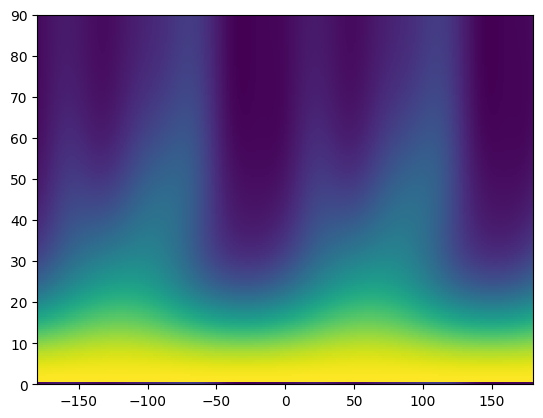

In [6]:
#Apply the beamforming fomrula

wind = 4096

for i in range(0, len(p) - wind, wind//2):
    p_fft = np.fft.fft(p[i:i+wind].T)
    p_star = np.conj(p_fft)

    aux = p_fft @ p_star.T

    for j in range(len(grid)):
        g_star = np.conjugate(grid[j].g)
        g_norm_squared = np.linalg.norm(grid[j].g)
        aux2 = aux.T @ g_star
        aux3 = aux2 @ grid[j].g
        grid[j].beam = (aux3/g_norm_squared).real

    beam_map = np.zeros((len(y_axis)-1, len(x_axis)-1))
    index = 0

    for j in range(len(y_axis)-1):
        for k in range(len(x_axis)-1):
            beam_map[j][k] = grid[index].beam
            index += 1
    
    #Printing
    max_value = 0
    x_max = 0
    y_max = 0
    for j in range(len(grid)):
        if grid[j].beam > max_value:
            x_max = grid[j].theta
            y_max = grid[j].phi
            max_value = grid[j].beam
        
    print(f"At time instant {wind/50000*i/2}: o = {x_max}, f = {y_max}.")      

    #Plotting    
        
    fig, ax = plt.subplots()
    ax.pcolormesh(x_axis, y_axis, beam_map)
    #fig.canvas.manager.set_window_title(f"Time instant {0.00002*i}")
    plt.show()
    break
